In [304]:
import scales

from classes import pitchClass

def isInGamut(note, gamutType = "dia", mode = "i"):
  gamut = scales.scales[gamutType][mode]
  contains = gamut.__contains__(pitchClass(note))
  return contains

In [305]:
from tests import testHigherCf, testLowerCf

from classes import intervalClassModTwelve

# todo detect gamut type and mode
def getAllCombos(melody, ctpAbove, gamutType = "dia", mode = "i"):
  combos = {
    'melody': melody,
    'intervalToNext': [],
    'ctpIsAbove': ctpAbove
  }
  prevNote = None
  intervals = [3,4,7,8,9,12,16,19]
  for note in melody:
    possibleNotes = []
    for interval in intervals:
      if ctpAbove:
        possibleNote = note + interval
      else:
        possibleNote = note - interval
      if isInGamut(possibleNote, gamutType, mode):
        possibleNotes.append(possibleNote)
    if(prevNote != None):
      combos["intervalToNext"].append(note - prevNote)
    combos[str(note)] = possibleNotes
    """ print("note: " + str(note) + "\n" + "prevNote: " + str(prevNote)) """
    prevNote = note
  return combos

In [306]:
""" print(getAllCombos(testHigherCf["a"], False)) """

' print(getAllCombos(testHigherCf["a"], False)) '

In [307]:
def generateNodeString(position, cf, ctp):
  return '[' + str(position) + ',' + str(cf) + ',' + str(ctp) + ']'

In [308]:
import matplotlib
import networkx as nx
import classes as c

def visualize(G):
  nx.draw_spring(G, with_labels = True)
  matplotlib.pyplot.figure(figsize = (200,200))

def removeIsolates(G):
  isolates = list(nx.isolates(G))
  G.remove_nodes_from(isolates)
  

In [309]:
def isValidMove(prevCf, nextCf, prevCtp, nextCtp):
  isCons = c.isConsonant(nextCf, nextCtp)
  isDirPerf = c.isDirectPerfect(prevCf, nextCf, prevCtp, nextCtp)
  isNotDirPerf = not isDirPerf
  isInRange = prevCtp - 12 <= nextCtp <= prevCtp + 12
  return isCons and isInRange and not isNotDirPerf

def addNodeAndEdge(G, melodyData, curNoteIndex, posOverride = False):
  melody = melodyData['melody']
  lastNoteIndex = len(melody) - 1
  nextNoteIndex = curNoteIndex + 1
  curNote = melody[curNoteIndex]
  if curNoteIndex < lastNoteIndex:
    nextNote = melody[curNoteIndex + 1]
    if not posOverride:
      nextMoves = melodyData[str(nextNote)]
    else:
      nextMoves = posOverride
  else:
    nextNote = None
    nextMoves = []
  for possCtp in nextMoves:
    possStr = generateNodeString(curNoteIndex, curNote, possCtp)
    validMoves = []
    if(curNoteIndex < lastNoteIndex):
      for move in nextMoves:
        isValid = isValidMove(curNote, nextNote, possCtp, move)
        if(isValid):
          validMoves.append(move)
    if(validMoves):
      G.add_node(possStr)
      for move in validMoves:
        newNode = generateNodeString(nextNoteIndex, nextNote, move)
        G.add_node(newNode)
        G.add_edge(possStr, newNode)

In [310]:
def constructInitialGraph(melodyData, willPrint = False):
  melody = melodyData['melody']
  G = nx.DiGraph()
  prevNote = None
  curNoteIndex = 0
  lastNoteIndex = len(melody) - 1
  for note in melody:
    nextCf = curNoteIndex + 1
    nextMoves = []
    if(curNoteIndex < lastNoteIndex):
      nextMoves = melodyData[str(melody[nextCf])]
    validMoves = []
    #special cases for first and last nodes
    if(not curNoteIndex):
      if melodyData['ctpIsAbove']:
        posCtp = {note + 0, note + 3, note +7, note + 12, note + 16, note + 19}
      else:
        posCtp = {note, note - 12}
      nextMoves = melodyData[str(melody[1])]
      addNodeAndEdge(G, melodyData, curNoteIndex, posCtp)
    elif(curNoteIndex == lastNoteIndex):
      if melodyData['ctpIsAbove']:
        posCtp = {note, note + 12}
      else:
        posCtp = {note, note - 12}
      addNodeAndEdge(G, melodyData, curNoteIndex, posCtp)
    else:
      for possCtp in melodyData[str(note)]:
        possString = generateNodeString(curNoteIndex, note, possCtp)
        for move in nextMoves:
          isValid = isValidMove(note, melody[nextCf], possCtp, move)
          if(isValid):
            validMoves.append(move)
        if validMoves:
          moveString = generateNodeString(curNoteIndex + 1, melody[curNoteIndex + 1], possCtp)
          G.add_node(moveString)
          for move in validMoves:
            G.add_edge(possString, moveString)
        else:
          if G.has_node(possString):
            G.remove_node(possString)
    curNoteIndex += 1
  removeIsolates(G)
  if willPrint:
    print(G.nodes)
    print(G.edges)
  return G


In [311]:
def xTheNode(G, finalNode):
  for node in G.nodes:
    isPath = node.is_path(G, [node, finalNode])
    if not isPath:
      G.remove_nodes_from(node)
      print(str(node) + ' failed')
    else:
      print(str(node))

In [312]:
""" def pruneLeaves
  for node in G.nodes """

' def pruneLeaves\n  for node in G.nodes '

{'melody': [0, 2, 0], 'intervalToNext': [2, -2], 'ctpIsAbove': True, '0': [4, 7, 9, 12, 16, 19], '2': [5, 9, 11, 14, 21]}
['[2,0,5]', '[1,2,5]', '[2,0,9]', '[1,2,9]', '[2,0,11]', '[1,2,11]', '[2,0,14]', '[1,2,14]', '[2,0,21]', '[1,2,21]']
[('[1,2,5]', '[2,0,5]'), ('[1,2,9]', '[2,0,9]'), ('[1,2,11]', '[2,0,11]'), ('[1,2,14]', '[2,0,14]'), ('[1,2,21]', '[2,0,21]')]
[('[2,0,5]', 1), ('[1,2,5]', 1), ('[2,0,9]', 1), ('[1,2,9]', 1), ('[2,0,11]', 1), ('[1,2,11]', 1), ('[2,0,14]', 1), ('[1,2,14]', 1), ('[2,0,21]', 1), ('[1,2,21]', 1)]
DiGraph with 10 nodes and 5 edges


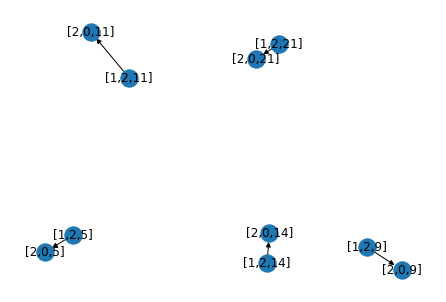

<Figure size 14400x14400 with 0 Axes>

In [313]:
combos = getAllCombos([0,2,0], True)
print(combos)
G = constructInitialGraph(combos, True)
print(G.degree())
visualize(G)

print(G)

In [314]:
""" import classes as c

print(isValidMove(0,0,5,3))
print(c.isConsonant(5,3)) """

' import classes as c\n\nprint(isValidMove(0,0,5,3))\nprint(c.isConsonant(5,3)) '

In [315]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [316]:
def getValidCombos(melody, ):
  data = getAllCombos(melody)
  
  #for note in melody:
    # remove invalid notes

def getLabels(i):
  str1 = "cf" + str(i)
  str2 = str1 + "_moves"
  return [str1, str2]

In [320]:
import pandas as pd
# Todo change to getvalidcombos once function is finished
moves = getAllCombos([0,5,4,9,7], True)
melody = moves["melody"]
perf = [0,5,7]

#create dataframe for the first two columns
firstNote = melody[0]
series = None
curIndex = 0
prevCf, prevCtp = getLabels(0)
series = pd.DataFrame(moves[str(firstNote)], columns = [prevCtp])
series["join_key"] = 1
series[prevCf] = firstNote

# create new data frame for each note in the melody
# join it to the previous dataframe
for i in range(1, len(melody)):
  note = melody[i]
  nextIndex = i + 1
  curMoves = moves[str(note)]
  cf, ctp = getLabels(i)
  addFrame = pd.DataFrame(curMoves, columns = [ctp])
  addFrame["join_key"] = 1
  addFrame[cf] = note
  series = series.merge(addFrame, how = "inner", on = "join_key")
  
  #filtering
  series = series.loc[
    # parallel unisons or octaves
    ~((abs(series[prevCf] - series[prevCtp]) % 12 == 0) & (abs(series[cf] - series[ctp]) % 12 == abs(series[prevCf] - series[prevCtp]) % 12)),
  ]
  series = series.loc[
    # parallel fourths
    ~((abs(series[prevCf] - series[prevCtp]) % 12 == 5) & (abs(series[cf] - series[ctp]) % 12 == abs(series[prevCf] - series[prevCtp]) % 12)),
  ]
  series = series.loc[
    # parallel fifths
    ~((abs(series[prevCf] - series[prevCtp]) % 12 == 7) & (abs(series[cf] - series[ctp]) % 12 == abs(series[prevCf] - series[prevCtp]) % 12))
  ]
  series = series.loc[
    (series[prevCtp] - 9 < series[ctp])
  ]
  series = series.loc[
    (series[ctp] < series[prevCtp] + 9)
  ]
  
  prevCf, prevCtp = cf, ctp

#Delete A column
series = series.drop("join_key", axis=1)

print(series)


     cf0_moves  cf0  cf1_moves  cf1  cf2_moves  cf2  cf3_moves  cf3  \
0            4    0          9    5          7    4         12    9   
1            4    0          9    5          7    4         12    9   
2            4    0          9    5          7    4         12    9   
3            4    0          9    5          7    4         12    9   
6            4    0          9    5         11    4         12    9   
..         ...  ...        ...  ...        ...  ...        ...  ...   
904         19    0         21    5         23    4         17    9   
907         19    0         21    5         23    4         21    9   
908         19    0         21    5         23    4         21    9   
910         19    0         21    5         23    4         21    9   
911         19    0         21    5         23    4         21    9   

     cf4_moves  cf4  
0           11    7  
1           14    7  
2           16    7  
3           19    7  
6           11    7  
..         ... 